## Toronto BikeShare Network

In [1]:
# Importing the required libraries

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

import powerlaw as pl

In [2]:
# change defaults to be less ugly
mpl.rc('xtick', labelsize=14, color="#222222") 
mpl.rc('ytick', labelsize=14, color="#222222") 
mpl.rc('font', **{'family':'sans-serif','sans-serif':['Arial']})
mpl.rc('font', size=16)
mpl.rc('xtick.major', size=6, width=1)
mpl.rc('xtick.minor', size=3, width=1)
mpl.rc('ytick.major', size=6, width=1)
mpl.rc('ytick.minor', size=3, width=1)
mpl.rc('axes', linewidth=1, edgecolor="#222222", labelcolor="#222222")
mpl.rc('text', usetex=False, color="#222222")

In [3]:
# Function Defintions, provided from Professor Towlson
# changed num = 20 to num = 10

# Function to plot a degree distribution graph (P(k) vs k graph)
def plot_degree_dist(G):
    
    degrees = [G.degree(n) for n in G.nodes()]
    kmin = min(degrees)
    kmax = max(degrees)
    
    if kmin>0:
        bin_edges = np.logspace(np.log10(kmin), np.log10(kmax)+1, num=10)
    else:
        bin_edges = np.logspace(0, np.log10(kmax)+1, num=10)
    density, _ = np.histogram(degrees, bins=bin_edges, density=True)

    fig = plt.figure(figsize=(6,4))

    log_be = np.log10(bin_edges)
    x = 10**((log_be[1:] + log_be[:-1])/2)
    plt.loglog(x, density, marker='o', linestyle='none')
    plt.xlabel(r"degree $k$", fontsize=16)
    plt.ylabel(r"$P(k)$", fontsize=16)

    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

In [4]:
# BONUS MATERIAL: Simple use of the powerlaw package to fit the degree distributions. 

def plot_deg_dist_and_fit(G, bins, color):
    deg = [val for (node, val) in G.degree()]
    kmin, kmax = min(deg), max(deg)
    be = np.logspace(np.log10(kmin), np.log10(kmax), bins) # logarithms of bin edges
    logbe = np.log10(be)
    # "x" values should be midway through each bin (in log space)
    x = 10**((logbe[1:] + logbe[:-1])/2)
    # plot empirical data
    p, _ = np.histogram(deg, bins=be, density=True)
    plt.loglog(x, p, color=color, linestyle='none', marker='o', alpha=0.65,
               markeredgecolor='none', label="N = {0}".format(len(G)))
    # plot theoretical fit. Here we define xmin and xmax, but the powerlaw package can determine the best choices of xmin and xmax for real data
    fit = pl.Fit(deg, xmin=min(deg), xmax=max(deg))
    print('gamma= ',fit.power_law.alpha)
    fit.power_law.plot_pdf(color=color)

## Read in edgelist as directed graph

In [5]:
# Read in the Bike share network

B = nx.read_edgelist('final-edges-counts.txt', create_using=nx.DiGraph(), data=True, edgetype=int, nodetype=int)


In [6]:
# Basic analysis

N = len(B)
L = B.size()
degrees = [B.degree(node) for node in B]
kmin = min(degrees)
kmax = max(degrees)


print("Number of nodes: ", N)
print("Number of edges: ", L)
print()
print("Average degree: ", 2*L/N)
print("Average degree (alternate calculation)", np.mean(degrees))
print()
print("Minimum degree: ", kmin)
print("Maximum degree: ", kmax)

Number of nodes:  567
Number of edges:  108372

Average degree:  382.2645502645503
Average degree (alternate calculation) 382.2645502645503

Minimum degree:  7
Maximum degree:  777


In [7]:
#print(degrees)
#print("")
#print(np.sort(degrees))


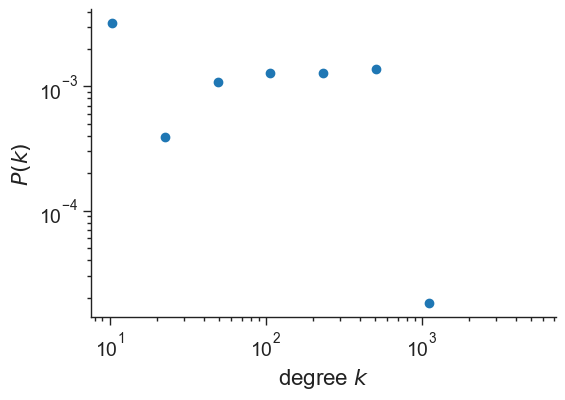

In [8]:
plot_degree_dist(B)

In [9]:
import csv

# Read data from CSV and add coordinates as attributes to the nodes in B
with open('final-nodes-latlon.csv', 'r') as csvfile:
    csv_reader = csv.DictReader(csvfile)
    for row in csv_reader:
        node_id = int(row['station_id'])
        latitude = float(row['lat'])
        longitude = float(row['lon'])
        # Check if the node exists in graph B before adding attributes
        if node_id in B:
            nx.set_node_attributes(B, {node_id: (latitude, longitude)}, 'pos')

In [10]:
# Check if nodes have the attributes
pos = nx.get_node_attributes(B, 'pos')
#print(pos)
print(len(pos))

567


## Change graph from directed to undirected

In [11]:
# https://stackoverflow.com/questions/56169907/networkx-change-weighted-directed-graph-to-undirected
# Used the code from above to aggregate our weighted edges & create an undirected graph

U = B.to_undirected()
for node in B:
    for ngbr in nx.neighbors(B, node):
        if node in nx.neighbors(B, ngbr):
            U.edges[node, ngbr]['weight'] = (
                B.edges[node, ngbr]['weight'] + B.edges[ngbr, node]['weight']
            )
            
# we will need to parse this to create a gephi edgelist for the visualization
#keeping just for testing
#U.edges.data('weight')

In [12]:
# Basic analysis for undirected network

N = len(U)
L = U.size()
degrees = [U.degree(node) for node in U]
kmin = min(degrees)
kmax = max(degrees)


print("Number of nodes: ", N)
print("Number of edges: ", L)
print()
print("Average degree: ", 2*L/N)
print("Average degree (alternate calculation)", np.mean(degrees))
print()
print("Minimum degree: ", kmin)
print("Maximum degree: ", kmax)

Number of nodes:  567
Number of edges:  69191

Average degree:  244.0599647266314
Average degree (alternate calculation) 244.0599647266314

Minimum degree:  5
Maximum degree:  440


In [13]:
#print(degrees)
#print("")
#print(np.sort(degrees))

#list(U.degree())
#den = nx.density(U)
#print(den)

connected_components = nx.connected_components(U)

largest_cc = max(nx.connected_components(U), key=len)

#Print the connected components
#for i, component in enumerate(connected_components):
#    print(f"Connected Component {i + 1}: {component}")

ncc = nx.number_connected_components(U)
print("Number of connected components: ", ncc)
print("Size of the largest component: ", len(largest_cc))

# Since Ng = N, we have a connected regime.
# We have a single giant component (refer to CPSC_572_672_W2L4 slide 50)

Number of connected components:  1
Size of the largest component:  567


In [14]:
# ...and calculate the clustering coefficient and average path length

C = np.mean(list(nx.clustering(U).values()))
d = nx.average_shortest_path_length(U,weight=None)

print("Average Clustering Coefficient: ", C)
print("Average Shortest Path: ", d)

Average Clustering Coefficient:  0.6707972714080139
Average Shortest Path:  1.6074560173500103


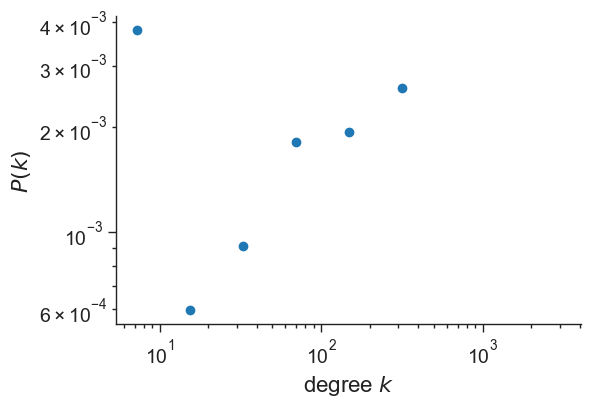

In [15]:
# degree distribution for undirected network
plot_degree_dist(U)

gamma=  1.2721069179106022


Text(0, 0.5, '$P(k)$')

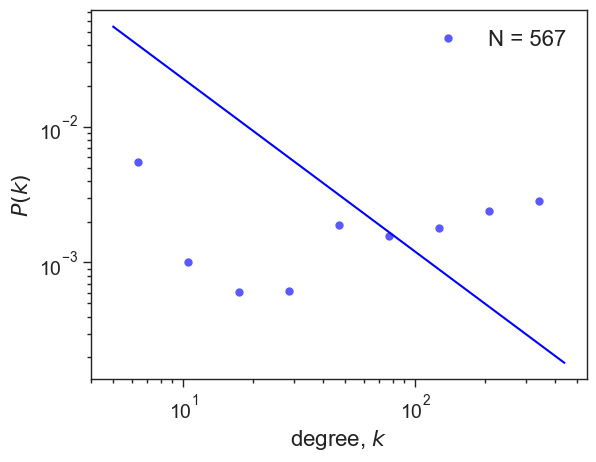

In [16]:
plot_deg_dist_and_fit(U, 10, 'b')
plt.legend(frameon=False, numpoints=1)
plt.xlabel(r"degree, $k$")
plt.ylabel(r"$P(k)$")

## Research Question 1:

In [17]:
# Research question 1:
degrees_dict = dict(U.degree())
# https://stackoverflow.com/questions/21992842/sorting-a-dictionary-by-second-value
# Sorting nodes by their degree
sorted_nodes = sorted(degrees_dict.items(), key=lambda x: x[1])

# Get the top 5 nodes with the lowest degrees
print("Top 5 nodes with the lowest degrees:")
for node, degree in sorted_nodes[:5]:
    print(f"Node {node}: Degree {degree}")

# Get the top 5 nodes with the highest degrees
print("\nTop 5 nodes with the highest degrees:")
for node, degree in sorted_nodes[-5:]:
    print(f"Node {node}: Degree {degree}")


print("")
# Calculate degree centrality for each node (station)
degree_centrality = nx.degree_centrality(U)

# Find the most used stations
most_used_stations = sorted(degree_centrality, key=degree_centrality.get, reverse=True)[:5]

# Find the least used stations
least_used_stations = sorted(degree_centrality, key=degree_centrality.get)[:5]

print("Most used stations:")
for station in most_used_stations:
    print(f"{station}: Degree Centrality {degree_centrality[station]}")

print("\nLeast used stations:")
for station in least_used_stations:
    print(f"{station}: Degree Centrality {degree_centrality[station]}")

print("")
node_7078_degree_centrality = degree_centrality.get(7078, "Error")
print("Degree centrality for node 7078:", node_7078_degree_centrality)

print("\nSeems to be a tie between node 7078 and 7038 for top 5th spot! They have the same value")

Top 5 nodes with the lowest degrees:
Node 7612: Degree 5
Node 7617: Degree 5
Node 7645: Degree 5
Node 7679: Degree 6
Node 7587: Degree 7

Top 5 nodes with the highest degrees:
Node 7078: Degree 433
Node 7016: Degree 434
Node 7246: Degree 438
Node 7015: Degree 438
Node 7076: Degree 440

Most used stations:
7076: Degree Centrality 0.7773851590106007
7246: Degree Centrality 0.773851590106007
7015: Degree Centrality 0.773851590106007
7016: Degree Centrality 0.7667844522968198
7038: Degree Centrality 0.765017667844523

Least used stations:
7612: Degree Centrality 0.0088339222614841
7617: Degree Centrality 0.0088339222614841
7645: Degree Centrality 0.0088339222614841
7679: Degree Centrality 0.010600706713780918
7587: Degree Centrality 0.012367491166077738

Degree centrality for node 7078: 0.765017667844523

Seems to be a tie between node 7078 and 7038 for top 5th spot! They have the same value


## Create gml file by putting the lat and lon separately

In [18]:
# add the lat + lon for each node value, run this after creating the undirected 
# don't run the prior lat+lon set up if you need to create a gml file

#import csv
#node_attributes = {}

# Read data from CSV and add coordinates as attributes to the nodes in B
#with open('final-nodes-latlon.csv', 'r') as csvfile:
#    csv_reader = csv.DictReader(csvfile)
#    for row in csv_reader:
#        node_id = int(row['station_id'])
#        latitude = float(row['lat'])
#        longitude = float(row['lon'])
#        node_attributes[node_id] = {"lat": latitude, "lon": longitude}

#nx.set_node_attributes(U, node_attributes)

In [19]:
# Check if nodes have the attributes
#pos = nx.get_node_attributes(U, 'pos')
#print(pos)
#print(len(pos))

In [20]:
# save as .gml file
#nx.write_gml(U, "test1.gml")

## Null Model

In [21]:
# Initial testing of null model, getting a feel for how random geometric graphs are generated
nodes = U.nodes()
pos = nx.get_node_attributes(U, "pos")
RGG = nx.random_geometric_graph(nodes, radius=0.01, pos=pos, seed=None)

print(RGG.number_of_nodes())
print(RGG.number_of_edges())

print("Is RGG connected? ", nx.is_connected(RGG))

567
5791
Is RGG connected?  False


In [82]:
# More testing of the null model and gathering calculations
rgg_c = [0] * 1001
rgg_p = [0] * 1001

radius_increment = 0.0001
num_graphs = 100
starting_radius = 0.01
current_radius = starting_radius

print("starting radius is:", current_radius)
for i in range(0, len(rgg_c)):
    #print(current_radius)
    current_radius += radius_increment

print(current_radius)

starting radius is: 0.01
0.11010000000000213


## Null Model: Random Geometric Graph (1000 ensemble)

In [90]:
# Initialize arrays to store clustering coefficient, path length, and modularity
rgg_cluster = []
rgg_path = []
rgg_modularity = []

# First round: generate random geometric graph ensemble 
# Using the an initial radius of 0.01 and incrementing it for each iteration
radius_increment = 0.0001
num_graphs = 500
starting_radius = 0.01
current_radius = starting_radius
randPath = 0

print("start radius is: ", current_radius)

# Get an ensemble of random geometric graph networks (initial 500/1000)
for i in range(num_graphs + 1):
    # Code takes very long to run, hence why a counter is printed to ensure that the iterations are working
    print(i)
    randGraph = nx.random_geometric_graph(nodes, radius=current_radius, pos=pos, seed=None)
    
    randCCoef = np.mean(list(nx.clustering(randGraph).values()))
    
    if nx.is_connected(randGraph)==True:
        randPath = nx.average_shortest_path_length(randGraph,weight=None)
        rgg_path.append(randPath)

    communities = list(nx.community.louvain_communities(RGG))

    randMod = nx.algorithms.community.modularity(RGG, communities)

    rgg_modularity.append(randMod)
    rgg_cluster.append(randCCoef)
    
    current_radius += radius_increment

print("End of ensemble: ", num_graphs, "and end radius is: ", current_radius)

start radius is:  0.01
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271

In [91]:
# Sanity check that the arrays were populated correctly
print(rgg_cluster)
print(rgg_path)
print(rgg_modularity)

[0.5850226224131194, 0.5839303934009441, 0.5861968821187789, 0.586947852798253, 0.5862666617041774, 0.5878806075553298, 0.5883675035673109, 0.5895907561315381, 0.5913420373454157, 0.5928471529223087, 0.5946981790861473, 0.5956179286220903, 0.6000660381321159, 0.6008570910428538, 0.6019266751845681, 0.6043662827359806, 0.606891153226008, 0.6115718647654554, 0.6119963984549285, 0.6142525232486156, 0.6132693317815994, 0.6149284987637094, 0.6170204076895632, 0.6186711830271427, 0.6251196596144615, 0.6252915300528904, 0.6257378604356983, 0.6264704691160995, 0.6280645558456355, 0.63056391861059, 0.6306455467534363, 0.630606820817131, 0.6326096404198096, 0.6389889565588663, 0.6411478428688091, 0.6419032895499005, 0.6429293333219454, 0.6440655085918812, 0.6453819761151085, 0.6460777225515093, 0.6469484273879078, 0.6465937396790883, 0.6473025590267464, 0.6481153305150804, 0.6480217971857897, 0.6491239298056348, 0.6496078964849822, 0.6503462465852268, 0.6511032428772944, 0.6523920652146317, 0.65

In [94]:
# Second round: continuing to generate random geometric graph ensemble (remaining 500)
# Using the end radius from the first round and incrementing it
radius_increment = 0.0001
num_graphs = 500
starting_radius = 0.0601000000000007
current_radius = starting_radius
randPath = 0

print("start radius is: ", current_radius)

# Get an ensemble of random geometric graph networks
for i in range(num_graphs + 1):
    # Code takes very long to run, hence why a counter is printed to ensure that the iterations are working
    print(i)
    randGraph = nx.random_geometric_graph(nodes, radius=current_radius, pos=pos, seed=None)
    
    randCCoef = np.mean(list(nx.clustering(randGraph).values()))
    
    if nx.is_connected(randGraph)==True:
        randPath = nx.average_shortest_path_length(randGraph,weight=None)
        rgg_path.append(randPath)

    communities = list(nx.community.louvain_communities(RGG))

    randMod = nx.algorithms.community.modularity(RGG, communities)

    rgg_modularity.append(randMod)
    rgg_cluster.append(randCCoef)
    
    current_radius += radius_increment

print("End of second ensemble: ", num_graphs, "and end radius is: ", current_radius)

start radius is:  0.0601000000000007
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
2

In [107]:
# Sanity check that the arrays were populated correctly (checking length of arrays)
print("Size of random geometric graph clustering coefficient array: ", len(rgg_cluster))
print("")

# Only could obtain 69 average path lengths from the 1000 graph generation
# as some iterations did not produce connected graphs
print("Size of random geometric graph path length array: ", len(rgg_path))
print("")
print("Size of random geometric graph modularity array: ", len(rgg_modularity))

Size of random geometric graph clustering coefficient array:  1002

Size of random geometric graph path length array:  69

Size of random geometric graph modularity array:  1002


In [102]:
# Another sanity check that the arrays were populated correctly
print(rgg_cluster)
print("")
print(rgg_path)
print("")
print(rgg_modularity)

[0.5850226224131194, 0.5839303934009441, 0.5861968821187789, 0.586947852798253, 0.5862666617041774, 0.5878806075553298, 0.5883675035673109, 0.5895907561315381, 0.5913420373454157, 0.5928471529223087, 0.5946981790861473, 0.5956179286220903, 0.6000660381321159, 0.6008570910428538, 0.6019266751845681, 0.6043662827359806, 0.606891153226008, 0.6115718647654554, 0.6119963984549285, 0.6142525232486156, 0.6132693317815994, 0.6149284987637094, 0.6170204076895632, 0.6186711830271427, 0.6251196596144615, 0.6252915300528904, 0.6257378604356983, 0.6264704691160995, 0.6280645558456355, 0.63056391861059, 0.6306455467534363, 0.630606820817131, 0.6326096404198096, 0.6389889565588663, 0.6411478428688091, 0.6419032895499005, 0.6429293333219454, 0.6440655085918812, 0.6453819761151085, 0.6460777225515093, 0.6469484273879078, 0.6465937396790883, 0.6473025590267464, 0.6481153305150804, 0.6480217971857897, 0.6491239298056348, 0.6496078964849822, 0.6503462465852268, 0.6511032428772944, 0.6523920652146317, 0.65

In [117]:
# Random geometric graph final calculations

mean_clustering_coefficient = np.mean(rgg_cluster)
std_clustering_coefficient = np.std(rgg_cluster)

mean_avg_path_length = np.mean(rgg_path)
std_avg_path_length = np.std(rgg_path)

print("Random Geometric Graphs Calculations:")
print("")

print("Mean Average Clustering Coefficient:", mean_clustering_coefficient)
print("Standard Deviation of Average Clustering Coefficient:", std_clustering_coefficient)

print("")

print("Mean Average Path Length:", mean_avg_path_length)
print("Standard Deviation of Average Path Length:", std_avg_path_length)

Random Geometric Graphs Calculations:

Mean Average Clustering Coefficient: 0.8207817411854854
Standard Deviation of Average Clustering Coefficient: 0.09068812735075146

Mean Average Path Length: 1.222396809771556
Standard Deviation of Average Path Length: 0.012585993469158197


In [119]:
# Random geometric graph final calculations: modularity

mean_modularity = np.mean(rgg_modularity)
std_modularity = np.std(rgg_modularity)

print("Random Geometric Graphs Calculations: Modularity")
print("")

print("Mean Modularity:", mean_modularity)
print("Standard Deviation of Modularity:", std_modularity)

Random Geometric Graphs Calculations: Modularity

Mean Modularity: 0.6169889292296658
Standard Deviation of Modularity: 0.0047848942067412895


In [69]:
# Copied output from the RGGs ensemble (would take too long to generate over again)
rgg_mean_clustering = [0.5850226224131194, 0.5839303934009441, 0.5861968821187789, 0.586947852798253, 0.5862666617041774, 0.5878806075553298, 0.5883675035673109, 0.5895907561315381, 0.5913420373454157, 0.5928471529223087, 0.5946981790861473, 0.5956179286220903, 0.6000660381321159, 0.6008570910428538, 0.6019266751845681, 0.6043662827359806, 0.606891153226008, 0.6115718647654554, 0.6119963984549285, 0.6142525232486156, 0.6132693317815994, 0.6149284987637094, 0.6170204076895632, 0.6186711830271427, 0.6251196596144615, 0.6252915300528904, 0.6257378604356983, 0.6264704691160995, 0.6280645558456355, 0.63056391861059, 0.6306455467534363, 0.630606820817131, 0.6326096404198096, 0.6389889565588663, 0.6411478428688091, 0.6419032895499005, 0.6429293333219454, 0.6440655085918812, 0.6453819761151085, 0.6460777225515093, 0.6469484273879078, 0.6465937396790883, 0.6473025590267464, 0.6481153305150804, 0.6480217971857897, 0.6491239298056348, 0.6496078964849822, 0.6503462465852268, 0.6511032428772944, 0.6523920652146317, 0.6531248887453625, 0.6536019293007633, 0.6547150945303172, 0.654171033414039, 0.6548974920035354, 0.6545764168148103, 0.6543464467987843, 0.6549715082021196, 0.654645786608686, 0.6548680672253027, 0.6555888439130281, 0.6568540335843471, 0.6571731379878594, 0.6582475237041402, 0.6592854585747796, 0.6600347167584393, 0.6598988388010428, 0.6600251276330311, 0.6651035197817377, 0.6659002754879447, 0.666139391534064, 0.6666816121101624, 0.6669471185993504, 0.6678462202791005, 0.6681168242574512, 0.6685369420923805, 0.6693230331192721, 0.668989811234642, 0.669434603731818, 0.6702082052197991, 0.6712388500530542, 0.6709927440634085, 0.6715229066550431, 0.6715999750503562, 0.6697877168035132, 0.6703673398461402, 0.6709204575120559, 0.6714008985551867, 0.6720176794744015, 0.6726334257773738, 0.6736327913494261, 0.6742268901165687, 0.6748109365801093, 0.6755827316110697, 0.6759995715020445, 0.6765050055536731, 0.6767723150137822, 0.6773931557282272, 0.6777171075566012, 0.6774209603741939, 0.6779361651740392, 0.6786714014694348, 0.6789475475204401, 0.6790385827492805, 0.6794535767825602, 0.6800259328819723, 0.6806010130913511, 0.6807717929412203, 0.6819785866620807, 0.6826689569409724, 0.6834024929803115, 0.6838237149474636, 0.6846132322209504, 0.6851505269773771, 0.6857397585543634, 0.6858092146044432, 0.6861399547472696, 0.6863654798605607, 0.6867314037099403, 0.6868480498368243, 0.6861678022038337, 0.6865630886921028, 0.6868087307004334, 0.687612616557017, 0.6914075359887855, 0.6917783691170064, 0.6924856007433617, 0.6926031690226226, 0.6931944967064931, 0.6935306659211034, 0.6937060765068386, 0.6945360463504892, 0.6952729820466854, 0.6976555165624564, 0.6992902498032265, 0.7000520703397183, 0.701100186550885, 0.7014938803931278, 0.7020715642004062, 0.7027411446491175, 0.7033852012355247, 0.7040342998896377, 0.7043387411035712, 0.7047921436816708, 0.7046290469025228, 0.705170888743501, 0.7045074948802197, 0.7049644570654485, 0.7043828310516093, 0.703332678209195, 0.7040391521717936, 0.7047009276507781, 0.7058328013982174, 0.7069094500314443, 0.7074323222945265, 0.7082065625463886, 0.7089276953236768, 0.7092128541595069, 0.7099874720198888, 0.7103947160468017, 0.7107462716743119, 0.7115440807619019, 0.7122267385996686, 0.7127206571100709, 0.7135738265780297, 0.7140366780246852, 0.7145216684930882, 0.7147684218309566, 0.7151965414284661, 0.7155603249138256, 0.7159641621803561, 0.7165895807999376, 0.7207075135146519, 0.7209597141122939, 0.7212416649074501, 0.7217443974798959, 0.7222972322895906, 0.7229959172618331, 0.7235413135149692, 0.7242975509488419, 0.7248027604326482, 0.7254244315468898, 0.7258916391322692, 0.7261900527581209, 0.7274689864530883, 0.728179859537236, 0.7291470987552655, 0.7298826660990959, 0.7301872211374092, 0.7305974452262471, 0.731260580510541, 0.7317605325797404, 0.7323576748240271, 0.7329345860673733, 0.7333892899465373, 0.7338578269864358, 0.7343393294717133, 0.7349002246889165, 0.7354745728645589, 0.7358045242109699, 0.7362043015713382, 0.7368229492065247, 0.7369875835886933, 0.7372966455153912, 0.7376674213192667, 0.7381600247198079, 0.7386534171959972, 0.7394883331219729, 0.7398303319875231, 0.7400736807250011, 0.7408290585258358, 0.7412416538856438, 0.7415621551476955, 0.7419081875589438, 0.7424440709443901, 0.7427474361842898, 0.7432615543817269, 0.7432829041638768, 0.7437887766260582, 0.7443283638046874, 0.7443740664636709, 0.7448151345923064, 0.7462089567857504, 0.7465203113769625, 0.7468486328298127, 0.7473058601580838, 0.7470582561692659, 0.74734414561507, 0.7476287205693759, 0.748110031792339, 0.7485525886699744, 0.7494175562310392, 0.7502158873712028, 0.7504919074531647, 0.75069745588799, 0.7509084110570077, 0.7514505537521569, 0.751741440442463, 0.7521202399051272, 0.7524991356842096, 0.7529268613525545, 0.7510565138962333, 0.7515080565736111, 0.7517926067020145, 0.7523872809940277, 0.7528510204838786, 0.7533786210010868, 0.7539314876316611, 0.7544483313120396, 0.7548327552276063, 0.75519166438402, 0.7556165987610933, 0.7564567843278844, 0.7568223303259385, 0.7572333733713993, 0.7575055136578355, 0.7580572303763384, 0.7588240379128911, 0.7591430715030092, 0.759481216029071, 0.7598145869161129, 0.7600858828049245, 0.7610234494158327, 0.76139131083845, 0.7618180382907951, 0.7623077494975756, 0.7627777130268477, 0.7631122812959824, 0.7634480709201517, 0.7638869543475924, 0.7643149949497735, 0.7647800408714417, 0.7653139424278265, 0.765851784793493, 0.7663111484245135, 0.7666453205649505, 0.7670823255621034, 0.7675132192334481, 0.7680282675972123, 0.768515201760396, 0.7688103424243338, 0.7690976220405759, 0.7696307582570354, 0.7699548115953004, 0.7703605822474825, 0.7708996871319199, 0.7717554381296949, 0.7720831373817582, 0.77240239844095, 0.7726937476192108, 0.7730637825990765, 0.7735519099113232, 0.7745186789058331, 0.7747427164041238, 0.7750823997768836, 0.7755041656119358, 0.7759309408996531, 0.7762362786775738, 0.7765928996327761, 0.7786235671744252, 0.7789892009760839, 0.7795136753066988, 0.7797819808952585, 0.780119553117372, 0.780487234764549, 0.7808475346112882, 0.7813165729394949, 0.781681119678447, 0.7820828357735589, 0.7824106926651273, 0.7827825814844962, 0.7830928723180184, 0.7833011655127916, 0.7837161148930247, 0.7839744931827366, 0.7838176182465824, 0.7842259327140064, 0.7845438660035469, 0.7848258710118067, 0.7850613996187096, 0.7854281173958458, 0.7857131439330327, 0.786043547560435, 0.7865236423169821, 0.7868787456949725, 0.7872344637272307, 0.7881334123775972, 0.7884302311806662, 0.7886839441915543, 0.7890044263369251, 0.7893574331044552, 0.7896165601150231, 0.7900208262492107, 0.790366133552349, 0.7908151253314782, 0.791099270755975, 0.791484707848517, 0.7917500159505086, 0.7931998056047909, 0.7935366149932463, 0.7937693000819636, 0.7942036640455674, 0.7944900490443674, 0.7948147192059435, 0.7951317279409734, 0.7953825840716078, 0.7956724983929958, 0.7959770680792712, 0.7970900290123226, 0.7975133020497243, 0.7978618356261387, 0.7980948611154282, 0.7984110959532987, 0.7986551121030412, 0.7989306890498263, 0.7991689728112522, 0.7994002860096031, 0.7996901789479979, 0.7999724935384, 0.8002315224045314, 0.8005133091077653, 0.800802049821545, 0.8011302697172854, 0.8014408906574285, 0.8018454088211208, 0.802013999219859, 0.8023050720888525, 0.8026120669697137, 0.8028908257371697, 0.8033514190700352, 0.8036552525200131, 0.8040111927506085, 0.8043028407951794, 0.8046102363132104, 0.8048928194768042, 0.8051873806018072, 0.8054686107211914, 0.8056986133474158, 0.8060134992630679, 0.8064425711872594, 0.8066963355798957, 0.8069403939027354, 0.8075025473796731, 0.8076123124193111, 0.8079075050267146, 0.808250917384661, 0.8085333024977894, 0.8087594366722665, 0.8090245550876101, 0.8093211681562906, 0.8096577796024746, 0.8099528688557995, 0.8103115943256227, 0.8107030478182342, 0.8109517917950898, 0.8111727504368853, 0.8114667415349772, 0.8117551405341688, 0.8121170893529157, 0.8124892104600684, 0.8128860363381838, 0.8132809658476424, 0.8136392168365567, 0.8139599402577936, 0.8142160441194177, 0.8144816485133628, 0.8148375623218234, 0.8151087839784318, 0.815451346184225, 0.8156939196044164, 0.8160306730518725, 0.8162587421073795, 0.816490589652507, 0.8171139173928402, 0.817892534103125, 0.8182999637786188, 0.818563725207403, 0.8189173187409833, 0.8192263090023463, 0.8194830318706272, 0.8198040268210763, 0.8201716325474291, 0.8206058682243341, 0.8209718409997271, 0.8212775492923186, 0.8217235916641429, 0.8220422825509462, 0.8224244451610112, 0.8225950091363141, 0.822855101413601, 0.8231028330718897, 0.8233595385375777, 0.8237434424855712, 0.8240062822099519, 0.824282260625401, 0.8236335343160212, 0.8238851226652426, 0.8242629951366673, 0.8244384501172831, 0.8247249859948015, 0.8249717977026944, 0.8252645150669271, 0.8256073712350178, 0.8258070662940755, 0.8261416539130829, 0.8264297606090276, 0.8268217060196368, 0.8270677576708316, 0.8273092612691115, 0.8276346110971593, 0.8277639523877167, 0.828084978229038, 0.8283161984222048, 0.8286074717763392, 0.8288479653605028, 0.8291045634593516, 0.8294414723371507, 0.8296545218018737, 0.8299332118485502, 0.8304193894550925, 0.8307547095509428, 0.8308723322775039, 0.8311766131859466, 0.831378383542881, 0.8316564033152767, 0.8319294505333159, 0.8321942918923907, 0.8324236075659756, 0.8327168839513011, 0.8330144067012278, 0.8332959916557462, 0.8335751700260626, 0.8338239822375597, 0.8341533664762529, 0.8343898316891587, 0.834700996087469, 0.8349840029824735, 0.8353476393128864, 0.8356454847033851, 0.835916719372571, 0.836222963044403, 0.8364910285338991, 0.8370841299010785, 0.8373272243072489, 0.837629692688765, 0.8382904015658087, 0.8385727795387998, 0.8388361560788455, 0.8390713254240685, 0.8393237367241605, 0.8396398114495472, 0.8398922821153053, 0.8402264202468929, 0.8404689683230028, 0.8407037310268449, 0.841066153547476, 0.8413843098058332, 0.84165419309568, 0.8418717156033186, 0.8421410167390562, 0.842498227851698, 0.8428128391528363, 0.8430715517715737, 0.8429837451549614, 0.8433310460223553, 0.8435904093064861, 0.8439770484129476, 0.8442038926119311, 0.844520502609538, 0.8447261880591876, 0.8449885858218179, 0.8452732470972895, 0.8451029153357814, 0.8450916350699048, 0.8453577015216673, 0.8455644705667977, 0.8458497400461698, 0.8465463610598, 0.8468239810185164, 0.847138298567907, 0.8474662383756498, 0.8477190682807892, 0.8480014638166521, 0.8482111671787507, 0.8484372908127629, 0.8487170920281535, 0.8488954757965488, 0.849179129376684, 0.8494406150849053, 0.8496628512171502, 0.8499084556087736, 0.8501528715792936, 0.8504718648146244, 0.8506532322568174, 0.8509606811739048, 0.8512636156405687, 0.8515376389346191, 0.8517908784692007, 0.851974299856226, 0.8522270861648255, 0.8525241116593123, 0.8528196450815515, 0.8531752884079125, 0.8534430154748968, 0.8536886355663736, 0.8538493267903648, 0.8541530066846198, 0.8544609223626196, 0.8547319471694482, 0.8550106750905317, 0.8552908265174705, 0.8555637806254492, 0.8557766160799407, 0.8559922965900235, 0.8562850395650106, 0.8565044761898313, 0.8567779767622494, 0.8570448162913044, 0.8573082799015728, 0.8575798250235944, 0.8578740758890254, 0.8582001482486364, 0.8584801659882376, 0.8586886307871329, 0.8589138989204693, 0.8591961137329965, 0.8595502925848445, 0.8598021924286843, 0.8601275942483807, 0.8603365962298786, 0.8605129743467069, 0.8603682939530971, 0.8606010488005874, 0.8608271325206475, 0.8610876366419686, 0.8612358867160825, 0.8615247384904371, 0.8617520135726132, 0.861459486977324, 0.8615553379617314, 0.8618337194996082, 0.8618513002198951, 0.8621395890641667, 0.862354775438725, 0.8626406423175396, 0.8629261211051384, 0.8631607691653251, 0.8632987704094454, 0.8635632739876489, 0.863894372131169, 0.8641852267408855, 0.8644513315173463, 0.8645082322207157, 0.8647693948855403, 0.8650860253151355, 0.865373041931413, 0.8656307471884058, 0.8659195070872148, 0.8661729365872015, 0.8664943805542813, 0.8667165496422946, 0.8673784888336435, 0.8676462090290323, 0.867903583315534, 0.868151772353589, 0.8683502733973777, 0.8686217203303505, 0.8688141387879246, 0.8690520622930492, 0.8693089410951462, 0.8696399550253842, 0.8698124677525599, 0.8700778668382728, 0.8703295701917741, 0.8705341548103456, 0.8707938555815194, 0.8710245524844922, 0.8712678410520546, 0.8716634746792598, 0.8718942559723085, 0.8721331871990519, 0.8723226600459009, 0.8721776441285672, 0.8724229901208348, 0.8727148419026196, 0.8729895251995214, 0.8732815459815549, 0.8734653765213662, 0.8733887786671234, 0.873651056509926, 0.8739121482309555, 0.8741470985597639, 0.8744632450361151, 0.8746548616982674, 0.874909533187957, 0.8751068752618427, 0.8752890464641586, 0.875495132452365, 0.8757335803466529, 0.8759828816338701, 0.8762124533783558, 0.8767779766053909, 0.8770289707330224, 0.8772471277943797, 0.8775175994895361, 0.8776617290805251, 0.8778406220192468, 0.8781305853836695, 0.878076883037342, 0.8782941210396663, 0.8785153502775158, 0.8786964917355274, 0.8789106431577397, 0.8791238076536826, 0.8793390343588339, 0.8794436778192459, 0.8795915332388781, 0.8798394381649686, 0.8800317878369067, 0.8802343672327072, 0.8805009881801465, 0.8807260042248719, 0.88084030912119, 0.8810740919166461, 0.881271728327744, 0.8814739648321843, 0.88223405848975, 0.882425966193487, 0.8826432327614139, 0.8828740739284797, 0.8830728612333948, 0.8831455934073671, 0.8833497000307589, 0.8836061601094022, 0.883814777182027, 0.8840086990444357, 0.8841813362492265, 0.8843490189595976, 0.8845528576805995, 0.884765182005294, 0.8849763785633593, 0.8851050267652889, 0.8853217993809647, 0.885315636630234, 0.8854980559232151, 0.8857410925844021, 0.8859583559837151, 0.8861240304587935, 0.8862991926767082, 0.8865437908375489, 0.8867131038769712, 0.8868839078212977, 0.8870311935342836, 0.8872819198059471, 0.8874999955304386, 0.8876803809158377, 0.8879345027866351, 0.8881452942643161, 0.8883171529553877, 0.8885099826415194, 0.8886726678723814, 0.8888952416804409, 0.8890654266146284, 0.8892577851015886, 0.8894094838124516, 0.8895713917457169, 0.8896578069005153, 0.8898673992189109, 0.8901088847101877, 0.890492889655646, 0.8906938278151172, 0.8908269160315476, 0.891016370239078, 0.8908409706638741, 0.8909707159224319, 0.8911905204719179, 0.8913608427053147, 0.8915621118559273, 0.8917018217144624, 0.8918584913194793, 0.8920893428020684, 0.8923030359934703, 0.8925034335534456, 0.8927189814356126, 0.8928391337129188, 0.8930454600763688, 0.8932051695261739, 0.893414121520861, 0.8935974088072803, 0.893802108612205, 0.8939931150590463, 0.8942066440498683, 0.894359944888987, 0.8945428425087908, 0.8947082925458542, 0.894951082174918, 0.8951149570207739, 0.8952423855080154, 0.8954445375711214, 0.8956206031922753, 0.8958129956179952, 0.8957111646830922, 0.8958730277202149, 0.8960599564368212, 0.8962195063944917, 0.8964031861162117, 0.8965782632311515, 0.8967213957142206, 0.8968823926432062, 0.897123469422523, 0.8973190481295332, 0.8974472010978166, 0.8976525481926092, 0.897837724835383, 0.8980412246774965, 0.8985432969805113, 0.8987665570912122, 0.8989399132607396, 0.8991428267431538, 0.8993117848966053, 0.8999658936699569, 0.9001578141113967, 0.900325252592384, 0.900484433847601, 0.9006737419481615, 0.9008941855754998, 0.900897576619469, 0.9011042408563272, 0.9013074924242775, 0.9015396449641261, 0.9016945524738312, 0.9018723715607708, 0.9020679491806821, 0.9022220444357945, 0.9023684166436435, 0.9025516481787079, 0.902759621815695, 0.9029355267155219, 0.9031301754395749, 0.9033033270948454, 0.9034897114914046, 0.9036650726364014, 0.9038326961731005, 0.9039407043347012, 0.9041027724682928, 0.9042594346373896, 0.9044535094277565, 0.9046093336010474, 0.9048136393189198, 0.9049749672151142, 0.9051248989373004, 0.9053567294723859, 0.905534635534064, 0.9057181343138361, 0.9059060213115324, 0.9060887993549247, 0.906335686970045, 0.9064676037848105, 0.9066524111533033, 0.9068331174976602, 0.907016113198993, 0.907296436552179, 0.9074514991376202, 0.9076666678186383, 0.9078728483008144, 0.9080103982621945, 0.9081664311912155, 0.9082803064341006, 0.9085104683694329, 0.9087387802146047, 0.9088977978086241, 0.9091021766507116, 0.9092368601674872, 0.909376835105905, 0.9095483070305744, 0.909705820843357, 0.9098661485781695, 0.9100422093316922, 0.9101906125268417, 0.9103314840816521, 0.9105211164933957, 0.9106571847906713, 0.9108594825096883, 0.9110438923112885, 0.9112876557342967, 0.9114575485915603, 0.9116592966608686, 0.9118004627258294, 0.911978768413416, 0.9121303427179644, 0.9123138815274945, 0.9124947355136962, 0.9126531063125131, 0.9128225636406302, 0.9130220168692158, 0.9131599149217329, 0.9132942938533664, 0.9134277700440255, 0.9135651039744708, 0.9137374108964141, 0.9138944892224756, 0.9140475517189692, 0.9142599216861875, 0.9145067407766787, 0.9146525657735008, 0.9148061607538818, 0.9150406246003177, 0.9152307873077605, 0.9153895341045153, 0.9155519542105836, 0.9157225406046098, 0.9158492935701016, 0.9160083485423542, 0.9161802513923536, 0.9163410077711718, 0.9164353000022383, 0.9166099255143618, 0.9167900826609129, 0.9169664266828196, 0.9171399866794545, 0.9172936051482834, 0.9174144645531981, 0.9175631810143515, 0.9177508744066362, 0.9179163677270491, 0.918053989864938, 0.9181890366524883, 0.9183305705272199, 0.918491385803012, 0.9185710251179743, 0.9185840555776691, 0.9186874582221709, 0.918850718088213, 0.9189796476736611, 0.9191223760486542, 0.9192874294915532, 0.919472198802441, 0.9196233824089382, 0.9197984335024285, 0.9199764917843651, 0.9201827662136672, 0.920396384531198, 0.9205422004208906, 0.9207178319886707, 0.9209034719705622, 0.921010243841952, 0.9211842699348753, 0.9213391521469979, 0.9214671612430343, 0.9216236932960277, 0.9218404541751299, 0.9219640202750496, 0.9220874711241449, 0.9222435799932058, 0.9224134898712895, 0.9225851181433257, 0.9226863111206343, 0.9228358910086918, 0.92299606805921, 0.9230898823441288, 0.9232242887982589, 0.9233744154413346, 0.9235074474060498, 0.9236658842850028, 0.9238546273993407, 0.9239881556701528, 0.9241147585508256, 0.924288449054447, 0.9244585922245846, 0.924723060458527, 0.9248998877105015, 0.925023484970815, 0.9251830222121159, 0.9253494505924716, 0.9254694414695077, 0.9256104431216605, 0.9257571779880476, 0.9258744984878696, 0.9260224327508881, 0.92617678011325, 0.9262877662015192, 0.926420033092848, 0.9265035233496365, 0.9266375603567794, 0.9267836408652148, 0.9269156932061574, 0.9269965574990852, 0.92709668717251, 0.9272203482084047, 0.9273473207309079, 0.9274579342075788, 0.9276337781479909, 0.9277582760010533, 0.9274299699103496, 0.9275880370861267, 0.9278079381947459, 0.9279814983689169, 0.9281225257504648, 0.928320799017756, 0.9284912046435607, 0.9286267107352404, 0.9288140988699167, 0.9290401897100873, 0.9291763676581063, 0.9293225854084193, 0.9294576205821368, 0.9293232223384047, 0.9294744042973804, 0.9296271327359328, 0.9297477743703955, 0.9299015733230922, 0.9299834553096304, 0.9301413200198162, 0.9302700782886516, 0.9304660031005076, 0.9306122115401304, 0.9307186340849462, 0.9306756178532043, 0.9307552049120471, 0.9308970284031569, 0.9310151403582548, 0.9312393092565111, 0.931000061937264, 0.9311359265685341, 0.9310713234850166, 0.9312170910164921, 0.9311846517068885, 0.9312524164017677, 0.9313872141395397, 0.9315273586600705, 0.9317320013103173, 0.9318339755978551, 0.9319966788951669, 0.9321406016293146, 0.9322718435738447, 0.9324303329233495, 0.9324391268557537, 0.9326281997745222, 0.9327565518151237, 0.9329537058632545, 0.9331100744693835, 0.9332144448837885, 0.9332113500323054, 0.9333518036645198, 0.9335192474860782, 0.9336498169680737, 0.9337798685673158, 0.9339482169684246, 0.9341327349861666, 0.9342351244326579, 0.9343514024978014, 0.9344855019795629, 0.9346241359779242, 0.934731277052642, 0.9348310887466754, 0.9347287057957827, 0.9347970508795307, 0.934919933509076, 0.9350469167094538, 0.9351669012683241, 0.9353205876951858, 0.9354215819564948]

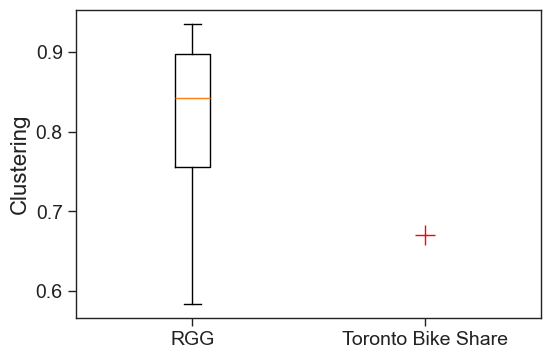

In [70]:
fig = plt.figure(figsize=(6,4))

plt.boxplot(rgg_mean_clustering)
plt.plot(2,C,'r',marker='+',markersize=15)
ax = plt.gca()
ax.set_xticks([1,2],labels=['RGG','Toronto Bike Share'])
plt.ylabel('Clustering')
plt.xlim([0.5,2.5])
plt.show()

In [68]:
# Copied output from the RGGs ensemble (would take too long to generate over again)
rgg_path_lengths = [1.244345978150454, 1.2438349505487314, 1.2431556577610758, 1.2427131826425113, 1.2422582434360998, 1.2416288069998318, 1.2411115473541858, 1.2407625528944728, 1.240189204853516, 1.2396906413396402, 1.2391920778257646, 1.2386187297848075, 1.2382074148858602, 1.2340319454571516, 1.233633094646051, 1.2332155477031803, 1.2326421996622232, 1.2321872604558117, 1.2317946416886347, 1.2313210063504527, 1.2308037467048067, 1.2303737356740891, 1.2299001003359071, 1.2295324097444238, 1.22876586834184, 1.228317161179352, 1.2279494705878686, 1.227519459557151, 1.2269710396918878, 1.2235309514461459, 1.223113404503275, 1.2223904874081553, 1.2219417802456671, 1.2207701559880595, 1.2202155040788727, 1.2198228853116957, 1.2193617140613606, 1.2187572058007865, 1.2182025538916, 1.2177912389926524, 1.2174173163572457, 1.2169810732826045, 1.2164949738565758, 1.2160213385183938, 1.215423062301743, 1.2149992833149488, 1.21451318388892, 1.2139211397161926, 1.213603305476097, 1.2132106867089198, 1.212861692249207, 1.2123631287353314, 1.2119642779242308, 1.2115529630252835, 1.2110668635992548, 1.2105184437339915, 1.2101507531425082, 1.20970204598002, 1.2091910183782975, 1.208835791874661, 1.2083995488000199, 1.2080131620767662, 1.2045481456553306, 1.203114775552938, 1.2027346208736078, 1.2023420021064308, 1.2019743115149475, 1.2016377811430814, 1.2012576264637513]

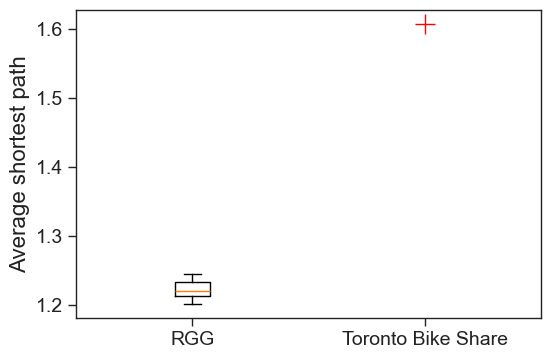

In [67]:
fig = plt.figure(figsize=(6,4))

plt.boxplot(rgg_path_lengths)
plt.plot(2,d,'r',marker='+',markersize=15)
ax = plt.gca()
ax.set_xticks([1,2],labels=['RGG','Toronto Bike Share'])
plt.ylabel('Average shortest path')
plt.xlim([0.5,2.5])
plt.show()

In [50]:
# Generating a random geometric graph to gather it's degree distribution
# Unable to gather degree distributions for all 1000 RGG ensemble

# Initialize arrays to store graph
rgg_graphs = []

# First round: generate random geometric graph ensemble 
# Using the an initial radius of 0.01 and incrementing it for each iteration
radius_incr = 0.0001
num_graphs = 1000
start_radius = 0.01
curr_radius = start_radius

print("start radius is: ", curr_radius)

# Get an ensemble of random geometric graph networks (initial 500/1000)
for i in range(num_graphs + 1):
    if (i == 200):
        randGraph = nx.random_geometric_graph(nodes, radius=curr_radius, pos=pos, seed=None)
        rgg_graphs.append(randGraph)
        break;
    
    curr_radius += radius_incr

print("End of ensemble: ", num_graphs, "and end radius is: ", curr_radius)

start radius is:  0.01
End of ensemble:  1000 and end radius is:  0.02999999999999988


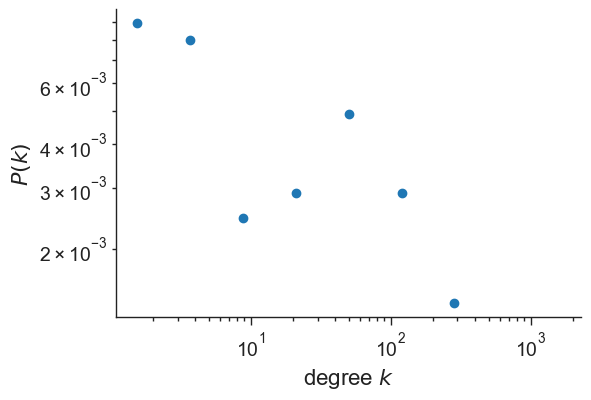

In [51]:
for graph in rgg_graphs:
    # degree distribution for undirected network
    plot_degree_dist(graph)